Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ X] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 133kB 8.8MB/s 
     |████████████████████████████████| 7.1MB 35.5MB/s 
     |████████████████████████████████| 614kB 28.1MB/s 
     |████████████████████████████████| 225kB 42.4MB/s 
     |████████████████████████████████| 768kB 9.8MB/s 
     |████████████████████████████████| 194kB 9.5MB/s 
     |████████████████████████████████| 51kB 11.2MB/s 
     |████████████████████████████████| 737kB 2.4MB/s 
     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145036 sha256=e6f31160667b900b3b4cee2cfe1a0d9e5e53c28c0fe0e3b667f30fe3d4950f0f
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=83939baad0a2d59b93d57850233c1dbaf6cb5055071dcc5bdb3ba60c59ecac12
  Stored in d

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# Likely needed imports

import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # not sure?



In [4]:
df.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019


In [5]:
df.shape

(23040, 21)

In [8]:
df.dtypes

# Got it. 

BOROUGH                                    int64
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                float64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
APARTMENT_NUMBER                          object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE           

In [0]:
# Change from string to date-time format for sale date

df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])

In [16]:
# Need to get rid of zeros in sale price... we did this on Monday

len(df.query('SALE_PRICE == 0'))

# Damn. 

6909

In [0]:
# Time to cut em out.

df = df[(df['SALE_PRICE'] > 0)] 

In [18]:
df.shape

#Butchered! 

(16131, 21)

In [0]:
df = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS')]


In [49]:
df.isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

In [0]:
df = df.drop(['EASE-MENT','APARTMENT_NUMBER'], axis='columns')

In [0]:
df = df.dropna()

In [51]:
#len(df.query(['BUILDING_CLASS_CATEGORY'] == '13 CONDOS - ELEVATOR APARTMENTS'))

df.query('SALE_PRICE > 20000000')

# Sounds legit.

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
12373,1,UPPER EAST SIDE (79-96),01 ONE FAMILY DWELLINGS,1,1494,11,A4,11 EAST 82ND STREET,10028.0,1.0,0.0,1.0,"2,554",7340.0,1899.0,1,A4,30139360,2019-03-04
20784,1,UPPER EAST SIDE (79-96),01 ONE FAMILY DWELLINGS,1,1492,125,A4,51 EAST 80TH STREET,10075.0,1.0,0.0,1.0,"2,350",8876.0,1899.0,1,A4,21500000,2019-04-15


In [52]:
df[(df['BUILDING_CLASS_CATEGORY'] == '13 CONDOS - ELEVATOR APARTMENTS')].shape

(0, 19)

In [67]:
# Thought it was weird to have values in this catagory other than 1 if you are 
# dealing with single family dwellings... so I'm going to cut some stuff here...

df['RESIDENTIAL_UNITS'].value_counts()

# Good. I cut a few hundred non-sense data points out...

1.0    3337
Name: RESIDENTIAL_UNITS, dtype: int64

In [0]:
df = df[(df['RESIDENTIAL_UNITS'] == 1)]

In [76]:
df['TOTAL_UNITS'].value_counts()

#Umm... get me an axe!

# Got em.

1.0    3279
Name: TOTAL_UNITS, dtype: int64

In [0]:
df = df[(df['TOTAL_UNITS'] == 1 )]

In [85]:
df['BUILDING_CLASS_AT_TIME_OF_SALE'].value_counts()

A1    1251
A5    1038
A2     525
A9     258
A0      86
A3      56
A4      45
A6      18
A7       2
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: int64

In [88]:
df['BOROUGH'].value_counts()

4    1613
5     765
3     579
2     296
1      26
Name: BOROUGH, dtype: int64

In [77]:
# Scatter with Ordinart Least Square line plot

px.scatter(df, x='GROSS_SQUARE_FEET', y='SALE_PRICE', trendline='ols' )

In [0]:
# "Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test."

#I'm created a new df that conditions on the SALE DATE being before April, then NOT before April

df_train = df[(df['SALE_DATE'] < '2019-04')]

In [79]:
df_train['SALE_DATE'].describe()

#Verify last date

count                    2626
unique                     75
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-03-30 00:00:00
Name: SALE_DATE, dtype: object

In [0]:
df_test = df[~(df['SALE_DATE'] < '2019-04')]

In [81]:
df_test['SALE_DATE'].describe()

# Verify first date

count                     653
unique                     25
top       2019-04-15 00:00:00
freq                       42
first     2019-04-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

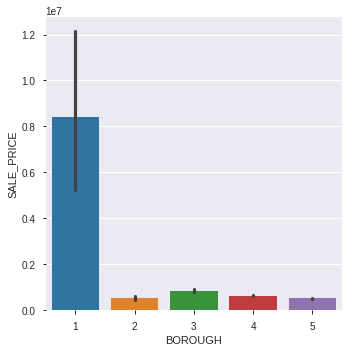

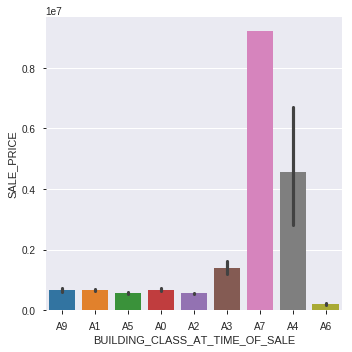

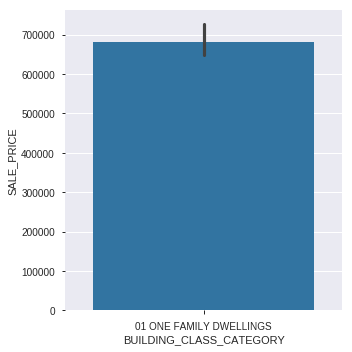

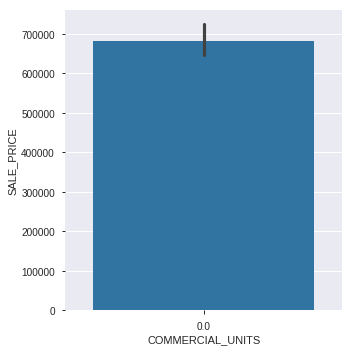

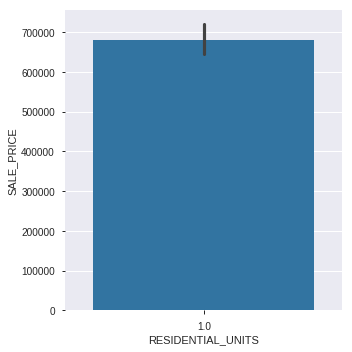

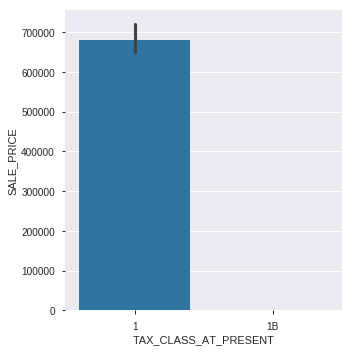

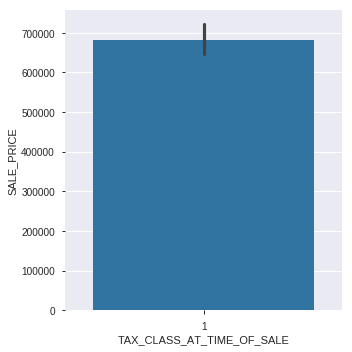

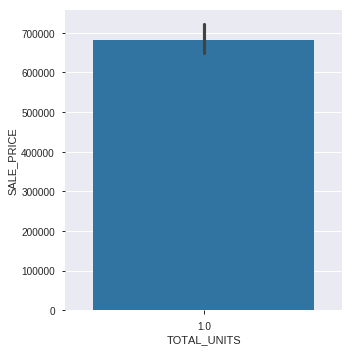

In [82]:
# Nice Catagorical Visualizer from lecture

for col in sorted(df_train.columns):
    if df_train[col].nunique() < 12:
      sns.catplot(x=col, y='SALE_PRICE', data=df_train, kind='bar')
      plt.show()

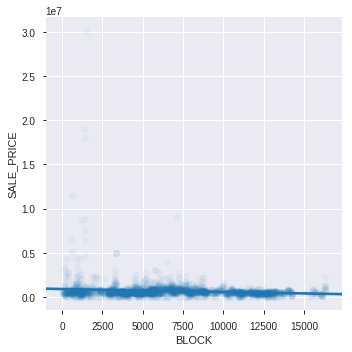

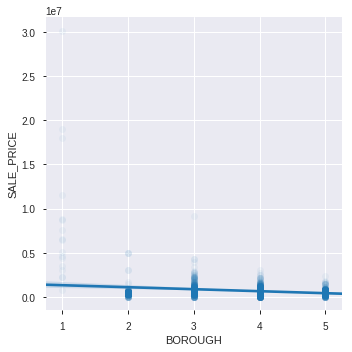

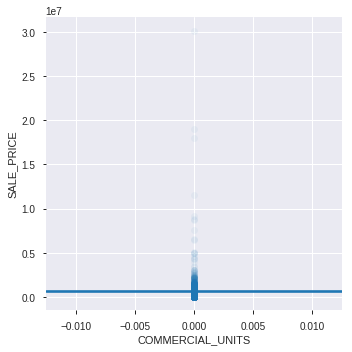

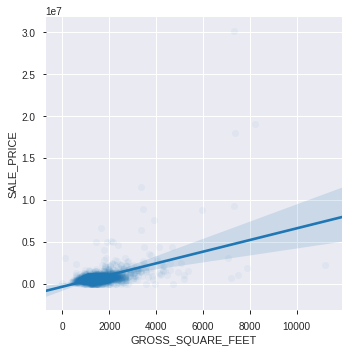

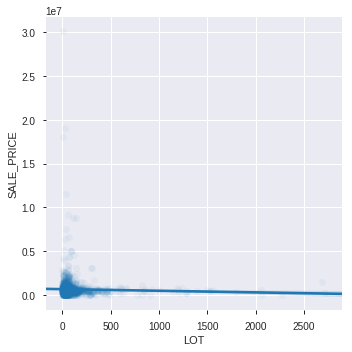

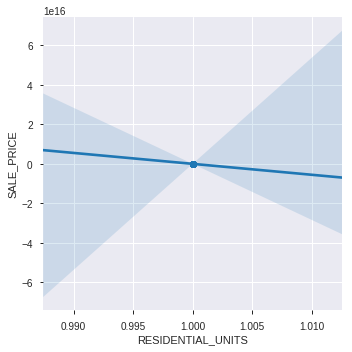

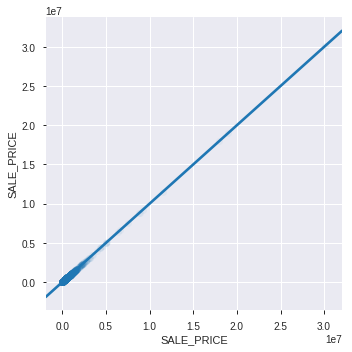

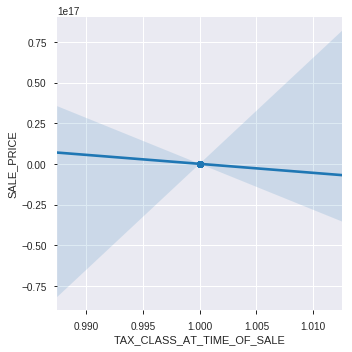

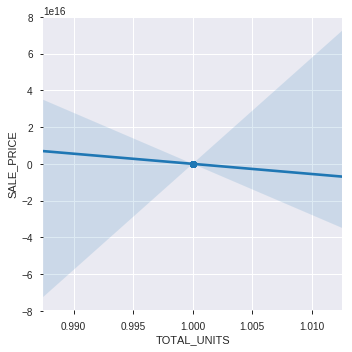

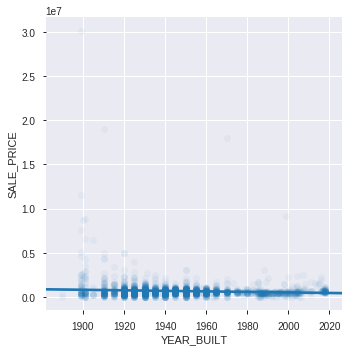

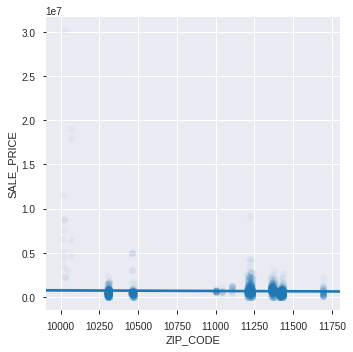

In [83]:
# Nice numberic feature visualizer from lecture:

numeric = df_train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y='SALE_PRICE', data=df_train, scatter_kws=dict(alpha=0.05))

In [0]:
# Good enough for now...

In [87]:
df.isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

### Still going down here: review of what next:

- Do one-hot encoding of categorical features.
-  Do feature selection with SelectKBest.
- Fit a linear regression model with multiple features.
- Get mean absolute error for the test set.
- As always, commit your notebook to your fork of the GitHub repo.

In [90]:
df_train.describe(exclude='number')

# Really there are only 2 Catagorical features left: 'BUILDING_CLASS_AT_TIME_OF_SALE', 'BOROUGH'

,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2626,2626,2626,2626,2626,2626,2626,2626
unique,193,1,2,12,2610,935,9,75
top,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,A1,22-40 93RD STREET,"4,000",A1,2019-01-31 00:00:00
freq,77,2626,2625,978,2,243,978,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [91]:
df_train.head(3)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02


In [92]:
df_train['BUILDING_CLASS_AT_TIME_OF_SALE'].value_counts()

A1    978
A5    826
A2    443
A9    209
A0     68
A3     49
A4     36
A6     16
A7      1
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: int64

In [94]:
# Look at interest level for first 5 apartments, one-hot encoded

import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(df_train['BUILDING_CLASS_AT_TIME_OF_SALE'])
encoded.head()

,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A7,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6
44,1,0,0,0,0,0,0,0,0
61,0,1,0,0,0,0,0,0,0
78,0,1,0,0,0,0,0,0,0
108,0,1,0,0,0,0,0,0,0
111,0,0,1,0,0,0,0,0,0


In [106]:
df_train.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01


In [108]:
# convert numbers to strings in BOROUGH to get categorical data

df_train['BOROUGH'] = df_train['BOROUGH'].astype(str) #df_train['BOROUGH'] = 
df_test['BOROUGH'] = df_test['BOROUGH'].astype(str)



dtype('O')

In [109]:
df_train.dtypes

BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE                         datetime64[ns]
dtype: object

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature ... 

# finding the value counts of each hood, then splicing the top ten (I think.)
top10 = df_train['NEIGHBORHOOD'].value_counts()[:10].index


In [114]:

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
df_train.loc[~df_train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
df_test.loc[~df_test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [0]:
from sklearn.feature_selection import f_regression, SelectKBest

# Note: this is much like fitting to linear regression model

selector = SelectKBest(score_func=f_regression, k=10) #SelectKBest has a bunch of methods see documenation...
X_train_selected = selector.fit_transform(, )


In [0]:
from sklearn.preprocessing import StandardScaler

target = 'SALE_PRICE'
high_cardinality = ['display_address', 'street_address', 'description', 'created']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')